# **Residual learning block**

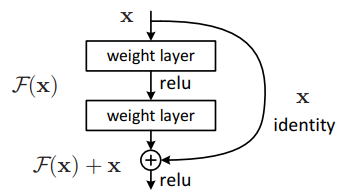

- Residual learning: substract x in original function $H(x)$ to make $F(x) = H(x) - x$, then $H(x)$ becomes $F(x) + x$ that $x$ is added to output.
- If $x$ is substracted in original function and added back later, gradient descent becomes simpler because the amount of learning required to reach target decreases.
- If residual learning gets input about weights in hidden layers, features can be maintained continuously to prevent information loss because $x$ is added directly.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class MLPResidualBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(MLPResidualBlock, self).__init__()
        self.fc1 = nn.Linear(in_features, out_features)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(out_features, out_features)

    def forward(self, x):
        residual = x
        print("x")
        print(residual)
        out = self.fc1(x)
        print("fc1")
        print(out)
        out = self.relu(out)
        print("relu")
        print(out)
        out = self.fc2(out)
        print("fc2")
        print(out)
        out += residual       # +x
        print("+ residual")
        print(out)
        out = self.relu(out)
        print("relu")
        print(out)
        return out

class XORModel(nn.Module):
    def __init__(self):
        super(XORModel, self).__init__()
        self.input_layer = nn.Linear(2, 8)
        self.res_block = MLPResidualBlock(8, 8)       # Residual Block
        self.output_layer = nn.Linear(8, 1)

    def forward(self, x):
        x = self.input_layer(x)
        print("input_layer")
        print(x)
        x = torch.relu(x)
        print("relu")
        print(x)
        x = self.res_block(x)
        print("res_block")
        print(x)
        x = self.output_layer(x)
        print("output_layer")
        print(x)
        x = torch.sigmoid(x)        # BCELoss gets input 0~1
        print("sigmoid")
        print(x)
        return x

X = torch.tensor([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
], dtype=torch.float32)

y = torch.tensor([
    [0],
    [1],
    [1],
    [0]
], dtype=torch.float32)

model = XORModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

input_layer
tensor([[ 0.1035,  0.3034, -0.0877,  0.4474, -0.0719,  0.1107,  0.0659,  0.4883],
        [ 0.7975,  0.2241,  0.4569,  0.6950, -0.4800,  0.0419, -0.1130, -0.0148],
        [-0.0920,  0.9622, -0.1712,  0.5150,  0.5515, -0.2427,  0.1393,  0.6517],
        [ 0.6020,  0.8829,  0.3734,  0.7626,  0.1434, -0.3115, -0.0396,  0.1486]],
       grad_fn=<AddmmBackward0>)
relu
tensor([[0.1035, 0.3034, 0.0000, 0.4474, 0.0000, 0.1107, 0.0659, 0.4883],
        [0.7975, 0.2241, 0.4569, 0.6950, 0.0000, 0.0419, 0.0000, 0.0000],
        [0.0000, 0.9622, 0.0000, 0.5150, 0.5515, 0.0000, 0.1393, 0.6517],
        [0.6020, 0.8829, 0.3734, 0.7626, 0.1434, 0.0000, 0.0000, 0.1486]],
       grad_fn=<ReluBackward0>)
x
tensor([[0.1035, 0.3034, 0.0000, 0.4474, 0.0000, 0.1107, 0.0659, 0.4883],
        [0.7975, 0.2241, 0.4569, 0.6950, 0.0000, 0.0419, 0.0000, 0.0000],
        [0.0000, 0.9622, 0.0000, 0.5150, 0.5515, 0.0000, 0.1393, 0.6517],
        [0.6020, 0.8829, 0.3734, 0.7626, 0.1434, 0.0000, 0.0000, 0.1

# **Dimension adjustment between $F(x)$ and $x$**

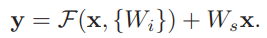

- If $F$ and $x$ have different dimension, multiply $W$ to $x$ so that $x$ can have same dimension of $F$.
- Not multiplying $W$ is better because original information of $x$ can be disappeared, but has to be used when it is essential.

In [ ]:
class MLPResidualBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(MLPResidualBlock, self).__init__()
        self.fc1 = nn.Linear(in_features, out_features)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(out_features, out_features)

        if in_features != out_features:
            self.shortcut = nn.Linear(in_features, out_features)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        residual = self.shortcut(x)       # Wx
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out += residual       # F(x) + Wx
        out = self.relu(out)
        return out

# **Plain network architecture**

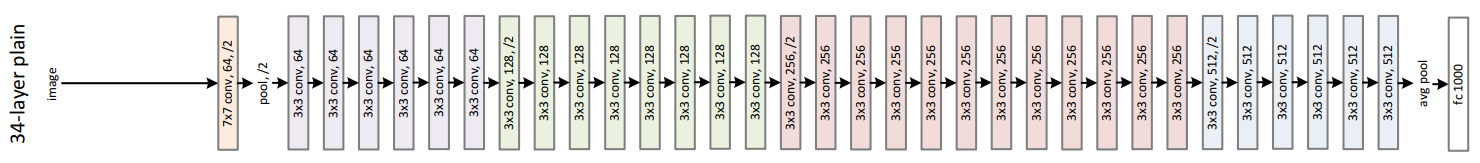

In [ ]:
class PlainNet(nn.Module):
    def __init__(self):
        super(PlainNet, self).__init__()
        self.conv1_block = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3),        # 224 -> 112
            nn.BatchNorm2d(64),       # make input values small and similar
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)        # 112 -> 56
        self.conv2_block = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),        # 56 -> 56
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv3_block = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),        # 56 -> 28
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.conv4_block = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),        # 28 -> 28
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.conv5_block = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),        # 28 -> 14
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.conv6_block = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),        # 14 -> 14
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.conv7_block = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1),        # 14 -> 7
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.conv8_block = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),        # # 7 -> 7
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))       # 7 -> 1
        self.fc = nn.Linear(512, 1000)

    def forward(self, x):
        x = self.conv1_block(x)
        x = self.maxpool(x)
        x = self.conv2_block(x)
        x = self.conv3_block(x)
        x = self.conv4_block(x)
        x = self.conv5_block(x)
        x = self.conv6_block(x)
        x = self.conv7_block(x)
        x = self.conv8_block(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# **Residual network architecture**

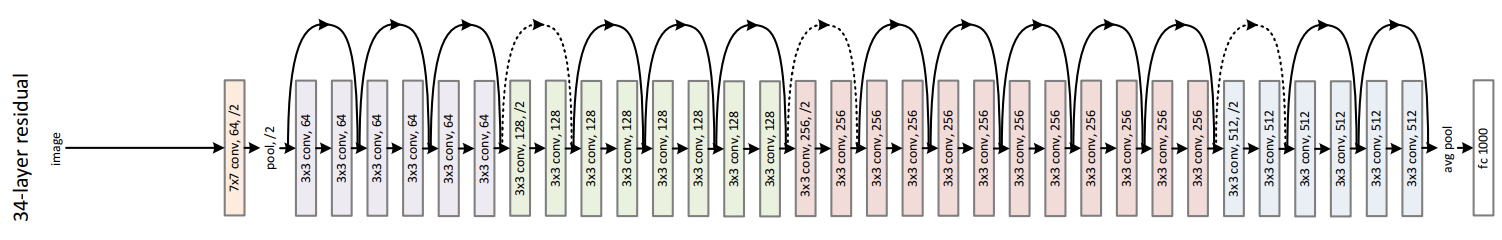

- Projection shortcut is used when dimensions are different in the code below.

In [ ]:
class ResidualBlock1(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock1, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x
        out = self.conv_block(x)
        out += identity
        return self.relu(out)


class ResidualBlock2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock2, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.relu = nn.ReLU()

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv_block(x)
        out += identity
        return self.relu(out)


class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv1_block = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2_block = nn.Sequential(
            ResidualBlock1(64),
            ResidualBlock1(64),
            ResidualBlock1(64)
        )
        self.conv3_block = nn.sequential(
            ResidualBlock2(64, 128),
            ResidualBlock1(128),
            ResidualBlock1(128),
            ResidualBlock1(128)
        )
        self.conv4_block = nn.sequential(
            ResidualBlock2(128, 256),
            ResidualBlock1(256),
            ResidualBlock1(256),
            ResidualBlock1(256),
            ResidualBlock1(256),
            ResidualBlock1(256)
        )
        self.conv5_block = nn.sequential(
            ResidualBlock2(256, 512),
            ResidualBlock1(512),
            ResidualBlock1(512)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 1000)

    def forward(self, x):
        x = self.conv1_block(x)
        x = self.maxpool(x)
        x = self.conv2_block(x)
        x = self.conv3_block(x)
        x = self.conv4_block(x)
        x = self.conv5_block(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# **Bottleneck block**

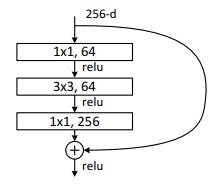

- The sequence of reducing dimension, performing 3x3 conv, increasing dimension to be original reduces the amounf of computation because 3x3 conv performs less dimension.
- The part of becoming less dimension looks like bottleneck.

In [ ]:
class ResidualBlock1(nn.Module):
    def __init__(self):
        super(ResidualBlock1, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(256, 64, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 256, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(256),
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x
        out = self.conv_block(x)
        out += identity
        return self.relu(out)

# **Prevention of vanishing gradient**

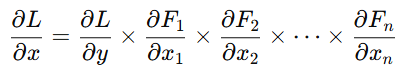
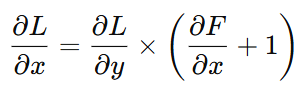

- This math, not mentioned in the paper, shows that gradient is not vanished because of +1, which can continue to learn normally.

In [ ]:
Lx1 = 5 * (0.1 + 1) * (0.1 + 1) * (0.1 + 1) * (0.1 + 1)
Lx2 = 5 * (0.1) * (0.1) * (0.1) * (0.1)

print(Lx1)
print(Lx2)

7.320500000000002
0.0005000000000000001
